<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>


## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

Загружаем данные:
'creditcard.csv'

In [4]:
# загрузка данных и структура данных
df=pd.read_csv('/content/sample_data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


Небольшой описательный анализ, используя метод describe()

In [5]:
# анализ данных
df.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,217924.000000,217924.000000,217924.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,...,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000,217923.000000
mean,76123.548641,-0.076580,-0.007946,0.227896,0.053671,-0.077288,0.036299,-0.032815,0.006923,0.005030,...,-0.008559,-0.030425,-0.011915,0.001970,0.045453,0.003773,0.000480,0.001942,90.443085,0.001849
std,37894.462317,1.919615,1.640362,1.475198,1.406391,1.365686,1.317210,1.221041,1.206486,1.127493,...,0.741705,0.703258,0.618360,0.605059,0.502583,0.487274,0.398457,0.327640,249.605534,0.042964
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,46470.000000,-0.952072,-0.592881,-0.494472,-0.814654,-0.760053,-0.724201,-0.570081,-0.191222,-0.661893,...,-0.225890,-0.533934,-0.167899,-0.346882,-0.262605,-0.331236,-0.068883,-0.046076,6.000000,0.000000
50%,71155.000000,-0.050774,0.072734,0.412167,0.054297,-0.137104,-0.230972,0.003781,0.036019,-0.069354,...,-0.037429,-0.018615,-0.025220,0.049198,0.085042,-0.061164,0.004286,0.016812,23.270000,0.000000
75%,115941.250000,1.233450,0.781329,1.175925,0.852649,0.512600,0.437389,0.524038,0.333272,0.618087,...,0.163152,0.456594,0.122768,0.425285,0.377374,0.255905,0.089100,0.078045,79.900000,0.000000
max,141096.000000,2.454930,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


Проверим на наличие пропусков в данных.

In [6]:
# проверка наличия пропусков в данных
print(df.isnull().sum())


Time      0
V1        0
V2        0
V3        1
V4        1
V5        1
V6        1
V7        1
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64



Пропусков нет?

Выведем названия столбцов.

In [7]:
# названия столбцов
print(df.columns)


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Еще раз оценим отношение классов целевой переменной.

In [ ]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении

In [ ]:
# df['Class'].value_counts()  - возвращает словарик,
# где ключ - уникальные значения в столбце Class кол-во значений
# value - сколько всего записей имело эти значения


# так как это словарь, то чтобы получить значения, обращаемся по ключу:


In [8]:
# вывод отношения классов целевой переменной через f строку

n_trans = round(df['Class'].value_counts()[0] / len(df) * 100, 3)  # процент обычных транзакций
f_trans = round(df['Class'].value_counts()[1] / len(df) * 100, 3)  # процент мошеннических транзакций

print(f'Обычные транзакции составляют {n_trans} % данных')
print(f'Мошеннические транзакции составляют {f_trans} % данных')


Обычные транзакции составляют 99.815 % данных
Мошеннические транзакции составляют 0.185 % данных


**Важно!**

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

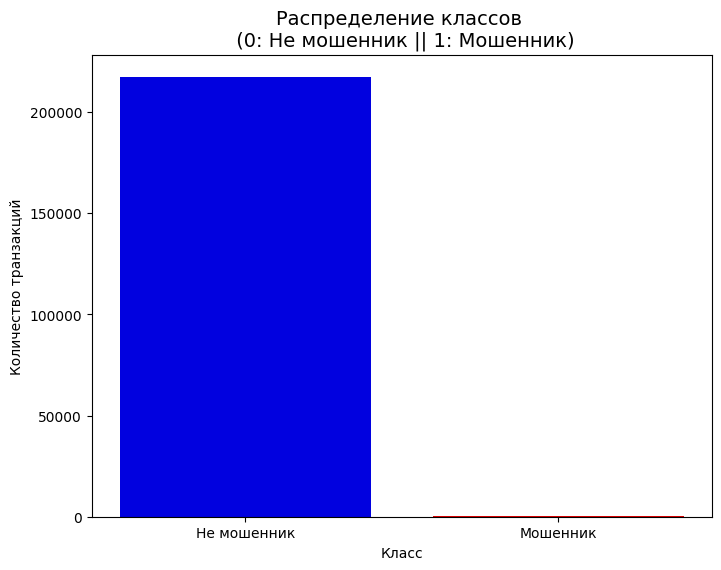

In [9]:
colors = ["#0101DF", "#DF0101"]  # синий для 0, красный для 1

# строим гистограмму целевой переменной
plt.figure(figsize=(8, 6))
plt.bar(df['Class'].value_counts().index, df['Class'].value_counts(), color=colors)

plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.xticks([0, 1], ['Не мошенник', 'Мошенник'])  # подписи на оси X
plt.ylabel('Количество транзакций')
plt.xlabel('Класс')

plt.show()


Построим распределения по суммам и времени транзакций.

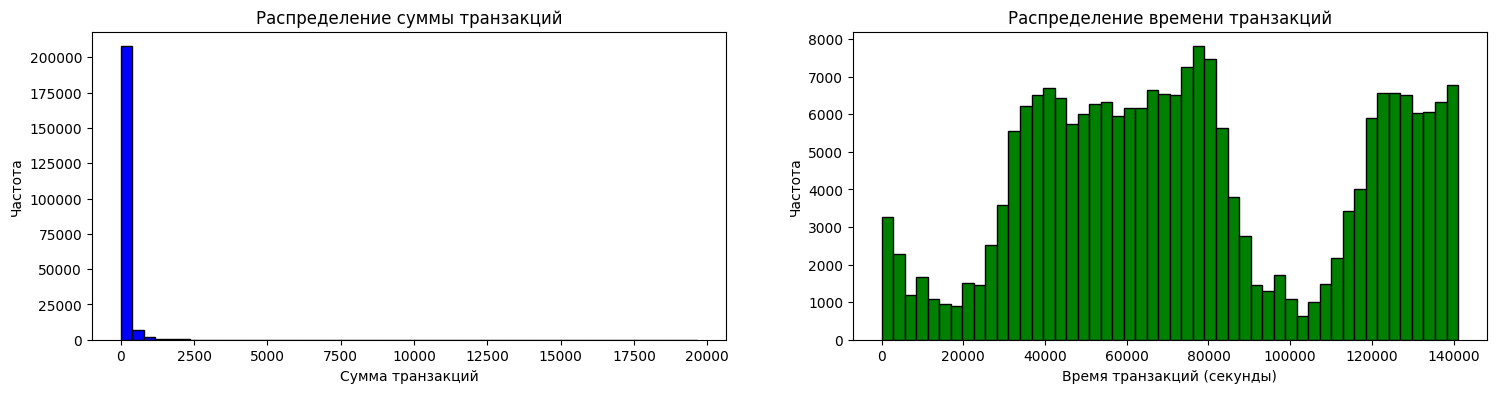

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = df['Amount']  # столбец с суммой транзакций
time_val = df['Time']  # столбец со временем транзакций

# строим график распределения суммы транзакций
ax[0].hist(amount_val, bins=50, color='blue', edgecolor='black')
ax[0].set_title('Распределение суммы транзакций')
ax[0].set_xlabel('Сумма транзакций')
ax[0].set_ylabel('Частота')

# строим график распределения времени транзакций
ax[1].hist(time_val, bins=50, color='green', edgecolor='black')
ax[1].set_title('Распределение времени транзакций')
ax[1].set_xlabel('Время транзакций (секунды)')
ax[1].set_ylabel('Частота')

plt.show()


### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!**

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.




In [13]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')

# масштабируем столбцы 'Amount' и 'Time' с использованием RobustScaler
original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1, 1))
original_Xtest['scaled_amount'] = rob_scaler.transform(original_Xtest['Amount'].values.reshape(-1, 1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1, 1))
original_Xtest['scaled_time'] = rob_scaler.transform(original_Xtest['Time'].values.reshape(-1, 1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
# получаем уникальные метки классов и их количество для тестового набора
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  1.    17.99  73.32 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  1.  ]
 [ 17.99]
 [ 73.32]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 

Распределение классов: 

Обучающий набор: [9.98141552e-01 1.85271224e-03 5.73595122e-06]
Тестовый набор: [0.99816451 0.00183549]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [14]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем первые 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
123885,77100.0,1.181521,-0.398024,1.144460,0.179451,-1.256733,-0.459144,-0.675114,0.045217,1.107952,...,-0.108434,-0.166427,0.046090,0.471839,0.101402,0.988291,-0.038373,0.019399,27.00,0.0
88900,62342.0,-0.684789,0.985782,1.639678,0.002674,0.045870,-0.643843,0.629901,-0.007696,-0.409741,...,-0.164195,-0.376719,0.145697,0.389785,-0.283580,0.070561,0.162740,0.108655,1.98,0.0
145441,86945.0,0.118273,1.024909,-0.375175,-0.524405,0.952459,-0.882698,0.971371,-0.129281,-0.096993,...,-0.332125,-0.801845,0.103360,0.638415,-0.414640,0.108273,0.223369,0.086250,2.69,0.0
211625,138489.0,-3.863286,-1.053020,-2.076205,-0.151983,1.141243,1.577898,0.843688,-0.157337,1.559178,...,-0.408701,0.630480,0.409861,-0.883171,-0.123106,-0.361421,-2.105208,1.449995,112.47,0.0
6870,8757.0,-1.863756,3.442644,-4.468260,2.805336,-2.118412,-2.332285,-4.261237,1.701682,-1.439396,...,0.667927,-0.516242,-0.012218,0.070614,0.058504,0.304883,0.418012,0.208858,1.00,1.0


In [15]:
# сохраняем полный набор данных
df.to_csv("/content/sample_data/creditcard_full.csv")

In [16]:
new_df.shape

(895, 31)

Распределение классов в подвыборке


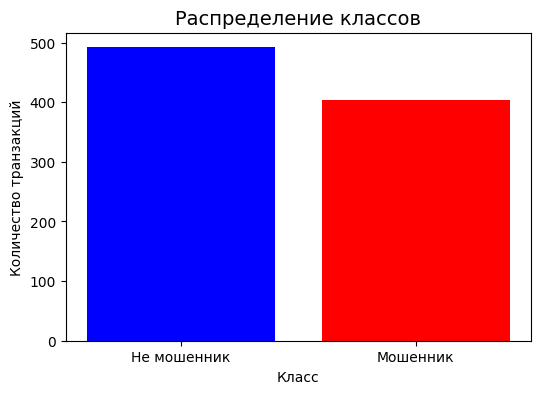

In [17]:
import matplotlib.pyplot as plt

print('Распределение классов в подвыборке')

# строим гистограмму распределения классов
plt.figure(figsize=(6, 4))
plt.bar(new_df['Class'].value_counts().index, new_df['Class'].value_counts(), color=['blue', 'red'])
plt.title('Распределение классов', fontsize=14)
plt.xticks([0, 1], ['Не мошенник', 'Мошенник'])  # подписи классов
plt.xlabel('Класс')
plt.ylabel('Количество транзакций')

plt.show()


### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


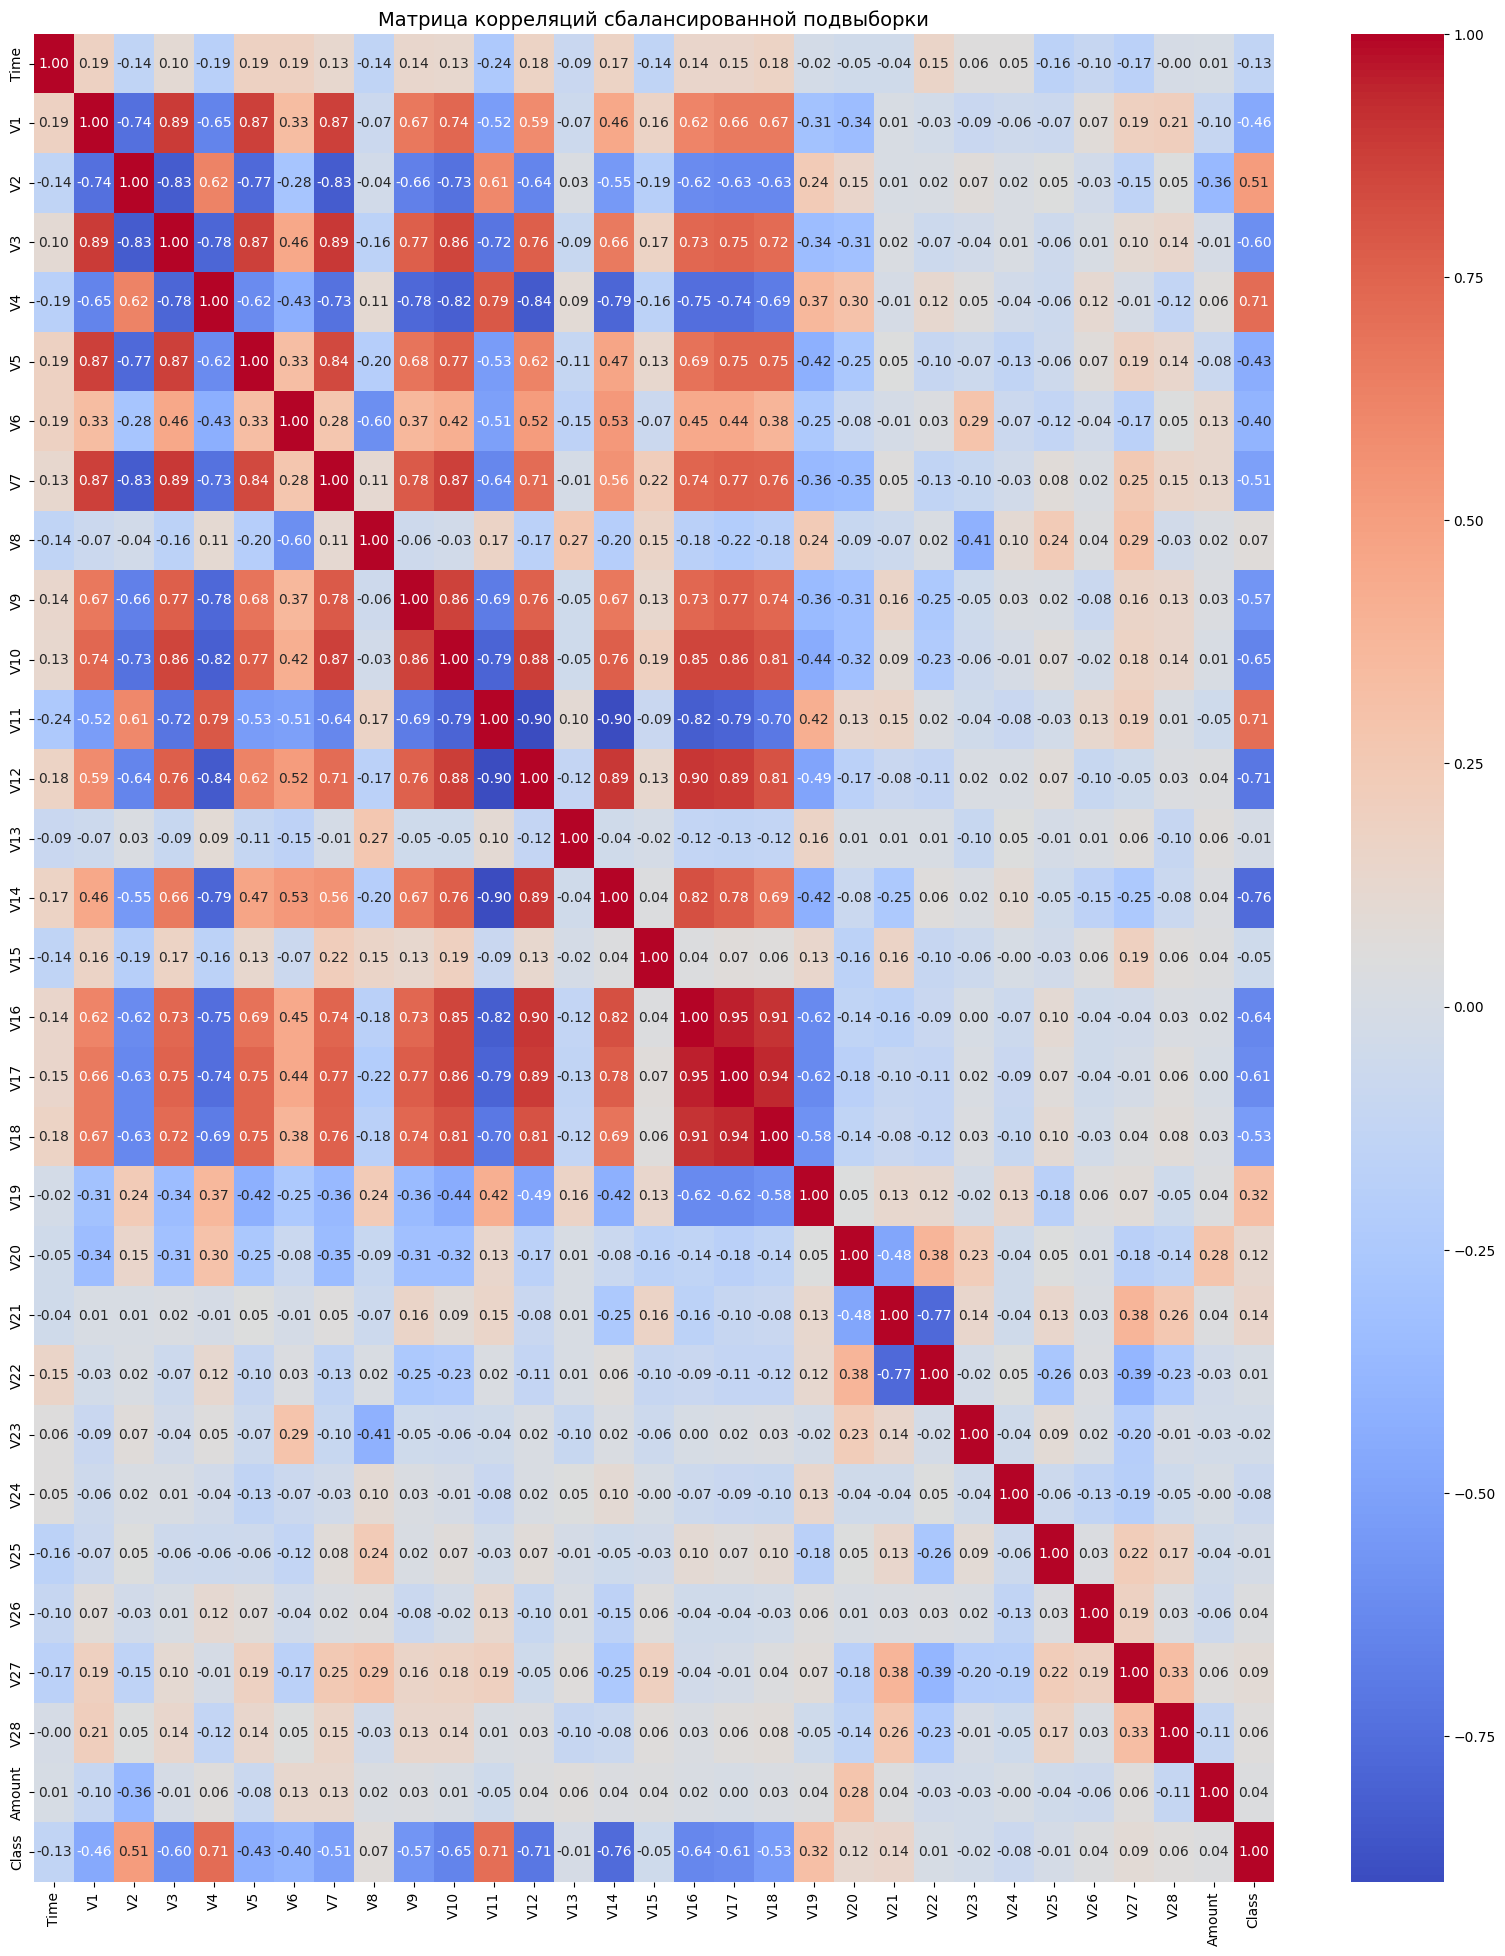

In [18]:
import seaborn as sns

# Строим корреляционную матрицу
correlation_matrix = new_df.corr()

# Создаём график с матрицей корреляций
f, ax = plt.subplots(1, 1, figsize=(20, 24))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=ax)

ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)

plt.show()


### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b> Какие признаки  имеют отрицательную корреляцию? Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Какие признаки  положительно коррелируют? То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>


**Важно!**

Всегда проверяйте, используете ли вы сбалансированную подвыборку в корреляционной матрице, иначе на корреляционную матрицу повлияет сильный дисбаланс между классами.

Построим теперь Boxplot.

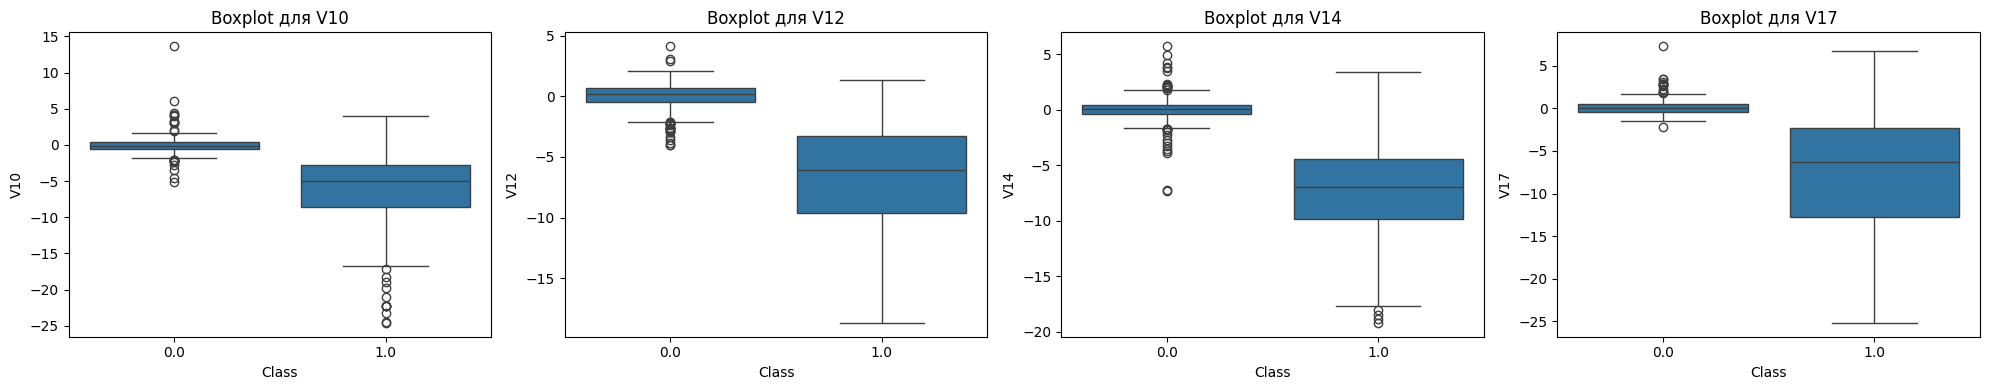

In [19]:
# Список признаков с отрицательной корреляцией (примерные признаки)
negative_corr_features = ['V10', 'V12', 'V14', 'V17']  # замените на реальные признаки из матрицы корреляции

f, axes = plt.subplots(ncols=4, figsize=(20, 4))

for i, feature in enumerate(negative_corr_features):
    sns.boxplot(x='Class', y=feature, data=new_df, ax=axes[i])
    axes[i].set_title(f'Boxplot для {feature}')

plt.tight_layout()
plt.show()


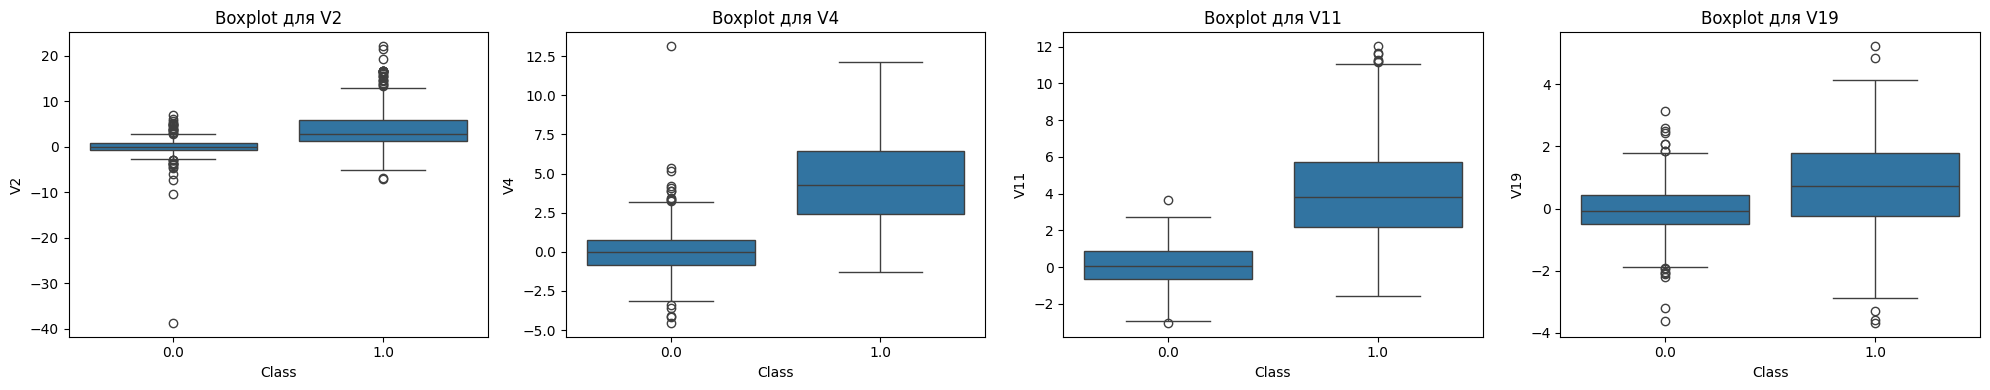

In [20]:
# Список признаков с положительной корреляцией (примерные признаки)
positive_corr_features = ['V2', 'V4', 'V11', 'V19']  # замените на реальные признаки из матрицы корреляции

f, axes = plt.subplots(ncols=4, figsize=(20, 4))

for i, feature in enumerate(positive_corr_features):
    sns.boxplot(x='Class', y=feature, data=new_df, ax=axes[i])
    axes[i].set_title(f'Boxplot для {feature}')

plt.tight_layout()
plt.show()


# Какие выводы можно сделать по построенным Boxplot?

Напоминаю.

0 - это не мошеннические транзакции

1 - мошеннические транзакции

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

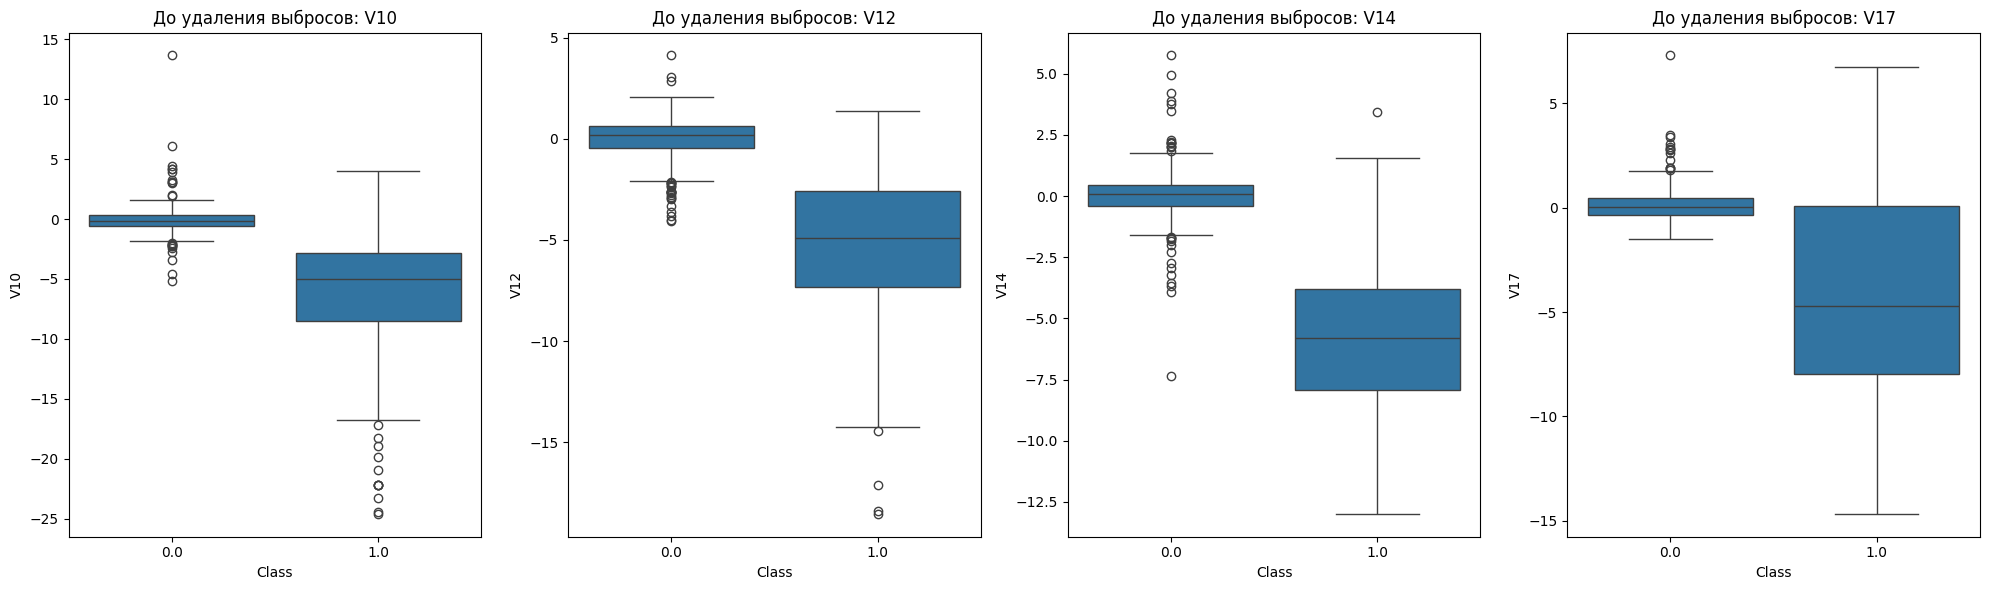

Выбросы успешно обработаны.


In [21]:
# Признаки с отрицательной корреляцией
negative_corr_features = ['V10', 'V12', 'V14', 'V17']  # замените на реальные признаки

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

axes = [ax1, ax2, ax3, ax4]

# Строим распределение и удаляем выбросы
for i, feature in enumerate(negative_corr_features):
    # Строим распределение до удаления выбросов
    sns.boxplot(x=new_df['Class'], y=new_df[feature], ax=axes[i])
    axes[i].set_title(f'До удаления выбросов: {feature}')

    # Рассчитываем IQR и границы выбросов
    Q1 = new_df[feature].quantile(0.25)
    Q3 = new_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Удаляем выбросы
    new_df = new_df[(new_df[feature] >= lower_bound) & (new_df[feature] <= upper_bound)]

plt.tight_layout()
plt.show()

print("Выбросы успешно обработаны.")


In [24]:
# Удаление выбросов из признака V17
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v17_iqr = q75 - q25
print('iqr: {}'.format(v17_iqr))

v17_cut_off = v17_iqr * 1.5
v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
print('Порог: {}'.format(v17_cut_off))
print('V17 нижняя граница: {}'.format(v17_lower))
print('V17 верхняя граница: {}'.format(v17_upper))

outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('Количество выбросов: {}'.format(len(outliers)))

new_df_without_outliers  = new_df.drop(new_df[(new_df['V17'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
print('----' * 44)



#### Для остальных признаков на основе V17 описать функцию, в качастве параметра которой будут вытупать выбросы других признаков
### Написать вызов функции по нужным признакам

Квартиль 25: -4.83555830647772 | Квартиль 75: 0.599717413841732
iqr: 5.435275720319453
Порог: 8.15291358047918
V17 нижняя граница: -12.9884718869569
V17 верхняя граница: 8.752630994320912
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
def remove_outliers(df, feature):
    """
    Функция для удаления выбросов из указанного признака на основе IQR.
    Возвращает DataFrame без выбросов.
    """
    # Получаем данные по признаку
    feature_values = df[feature].values

    # Рассчитываем Q1, Q3 и IQR
    q25, q75 = np.percentile(feature_values, 25), np.percentile(feature_values, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    print(f'Признак: {feature}')
    print(f'Квартиль 25: {q25} | Квартиль 75: {q75}')
    print(f'IQR: {iqr} | Нижняя граница: {lower} | Верхняя граница: {upper}')

    # Фильтруем выбросы
    df_no_outliers = df[(df[feature] >= lower) & (df[feature] <= upper)]
    print(f'Удалено выбросов: {len(df) - len(df_no_outliers)}')
    print('-' * 44)

    return df_no_outliers

# Список признаков для обработки выбросов
features_to_clean = ['V10', 'V12', 'V14', 'V17']

Признак: V10
Квартиль 25: -1.249094376269165 | Квартиль 75: 0.215450817852173
IQR: 1.464545194121338 | Нижняя граница: -3.4459121674511723 | Верхняя граница: 2.41226860903418
Удалено выбросов: 93
--------------------------------------------
Признак: V12
Квартиль 25: -0.7974626676460785 | Квартиль 75: 0.5503751638538865
IQR: 1.347837831499965 | Нижняя граница: -2.8192194148960263 | Верхняя граница: 2.572131911103834
Удалено выбросов: 50
--------------------------------------------
Признак: V14
Квартиль 25: -0.5511683519163852 | Квартиль 75: 0.4159965140155307
IQR: 0.967164865931916 | Нижняя граница: -2.0019156508142593 | Верхняя граница: 1.8667438129134046
Удалено выбросов: 43
--------------------------------------------
Признак: V17
Квартиль 25: -0.376032911541024 | Квартиль 75: 0.472995390747944
IQR: 0.849028302288968 | Нижняя граница: -1.649575364974476 | Верхняя граница: 1.7465378441813961
Удалено выбросов: 10
--------------------------------------------


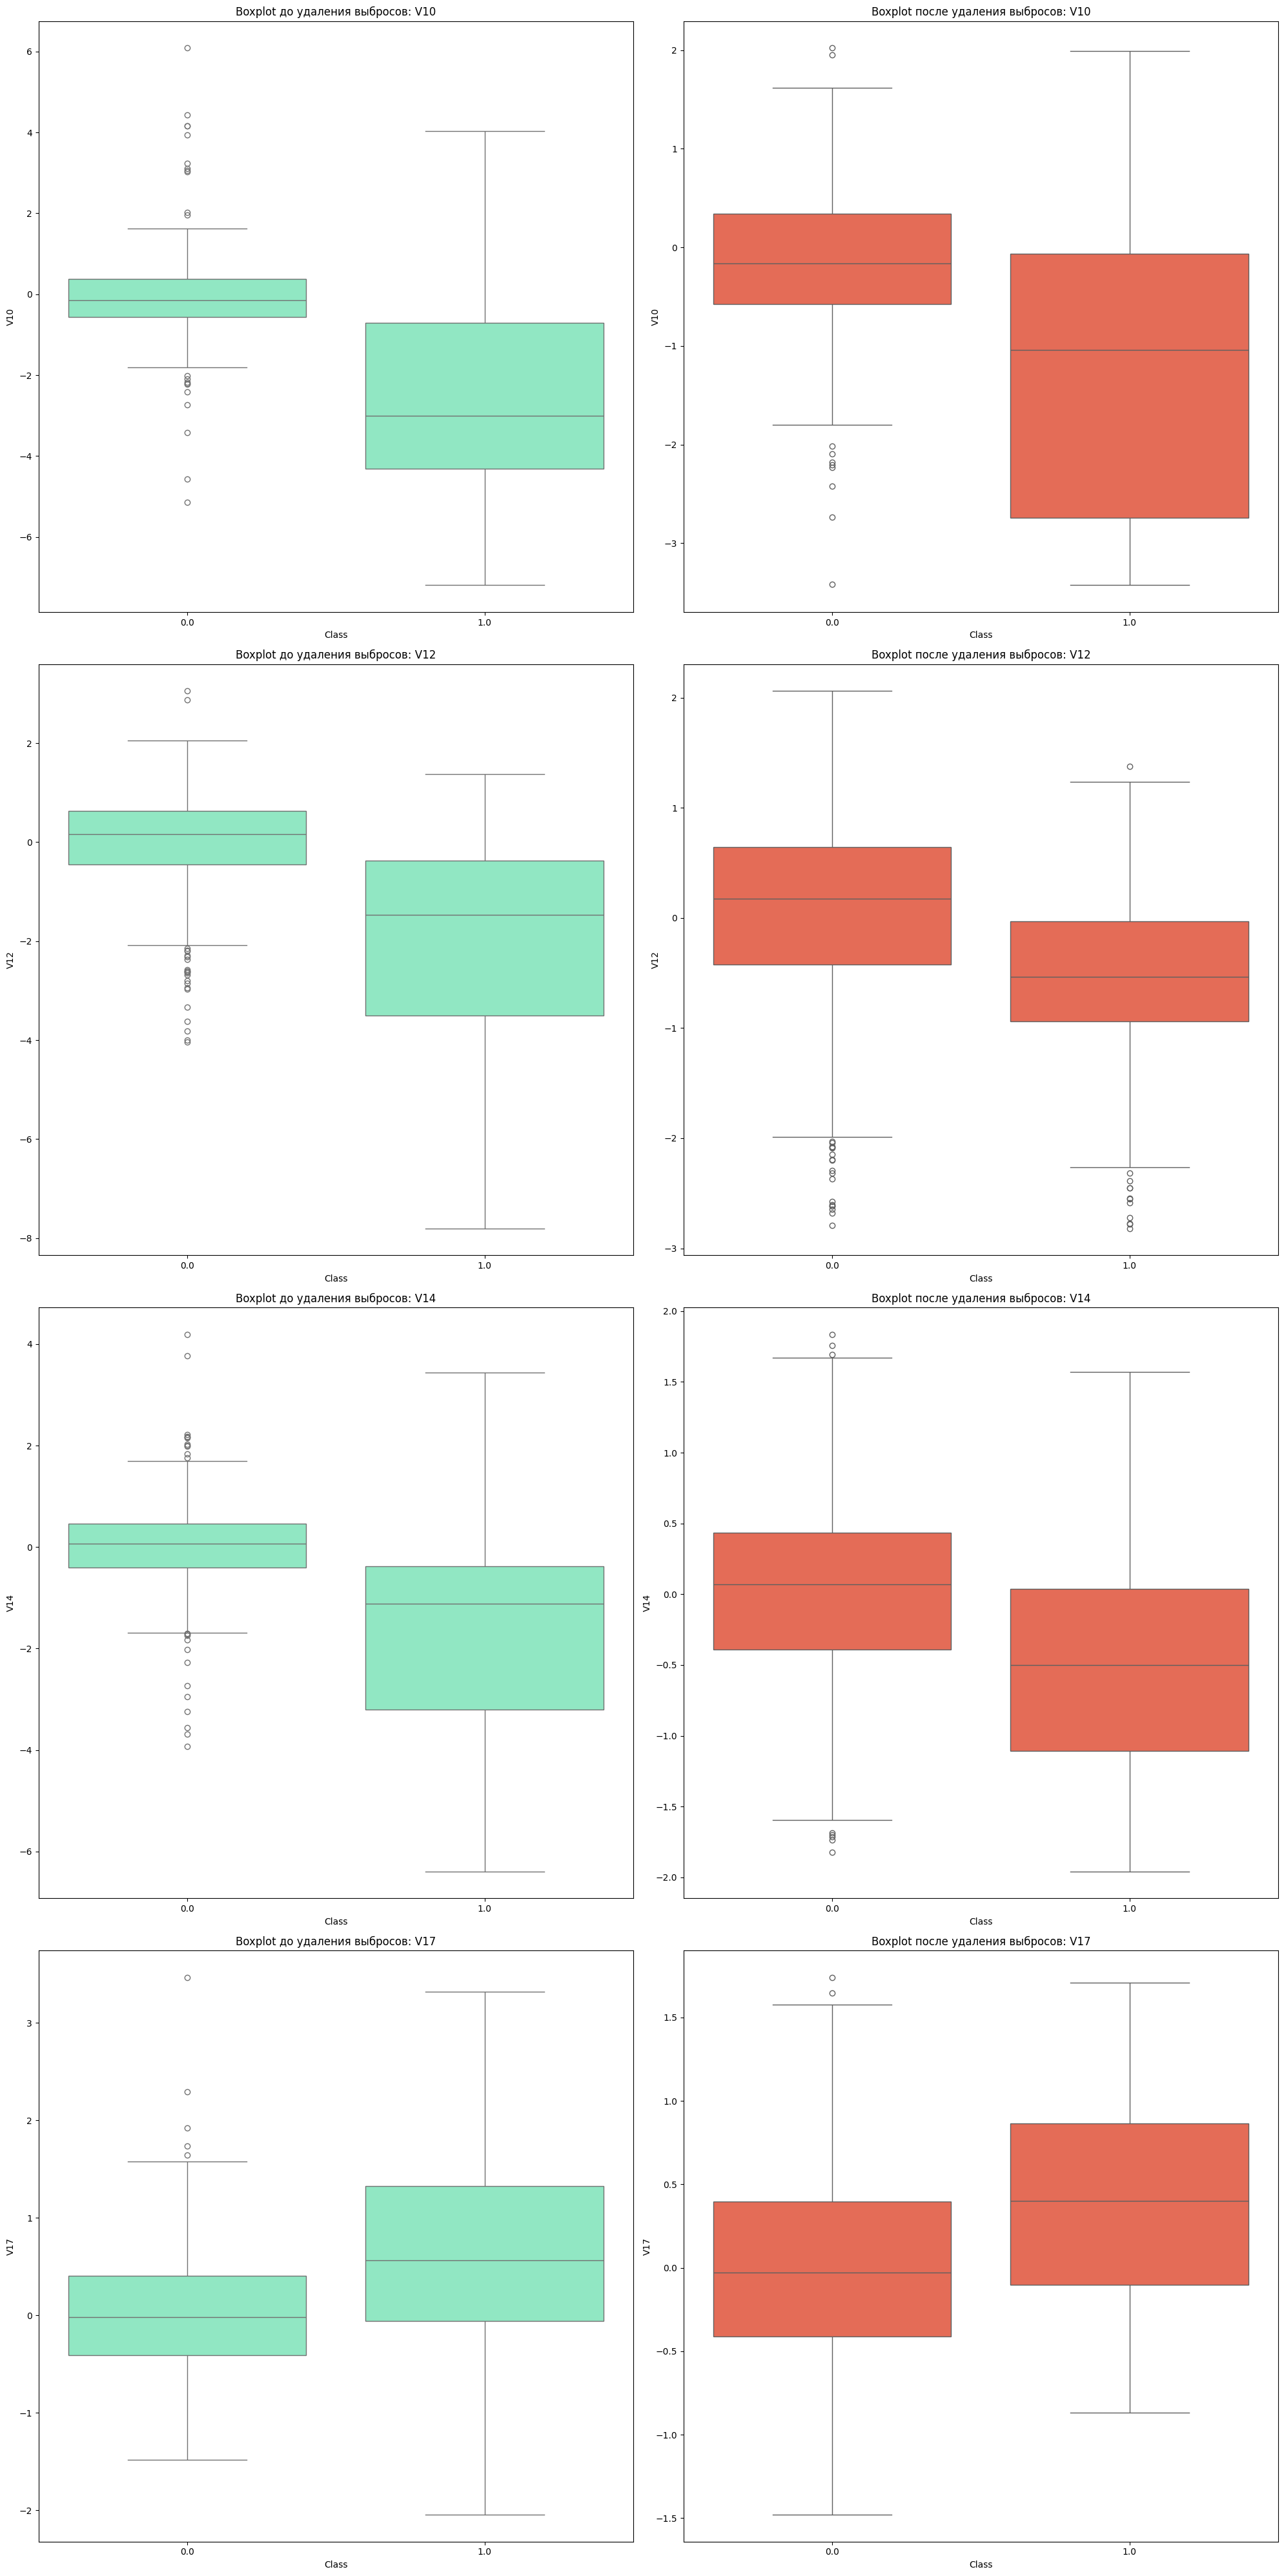

In [25]:
features_to_clean = ['V10', 'V12', 'V14', 'V17']

# Построение графиков до и после удаления выбросов
f, axes = plt.subplots(4, 2, figsize=(20, 40))
colors = ['#83F5C5', '#fc5b3f']

for i, feature in enumerate(features_to_clean):
    # Boxplot до удаления выбросов
    sns.boxplot(x='Class', y=feature, data=new_df, ax=axes[i, 0], color=colors[0])
    axes[i, 0].set_title(f'Boxplot до удаления выбросов: {feature}')

    # Удаляем выбросы
    new_df = remove_outliers(new_df, feature)

    # Boxplot после удаления выбросов
    sns.boxplot(x='Class', y=feature, data=new_df, ax=axes[i, 1], color=colors[1])
    axes[i, 1].set_title(f'Boxplot после удаления выбросов: {feature}')

plt.tight_layout()
plt.show()

In [32]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = new_df_without_outliers

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним понижение размерности с помощью трех различных техник понижения размерности.



In [33]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time

# Удаляем ненужные признаки
X = new_df.drop(['Class'], axis=1)
y = new_df['Class']

X.drop(['Time', 'Amount'], axis=1, inplace=True)  # Time и Amount не коррелируют с таргетом

# --- T-SNE алгоритм ---
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)
t1 = time.time()
print("T-SNE заняло {:.2f} сек".format(t1 - t0))

# --- PCA алгоритм ---
t0 = time.time()
pca = PCA(n_components=2, random_state=42)
X_reduced_pca = pca.fit_transform(X)
t1 = time.time()
print("PCA заняло {:.2f} сек".format(t1 - t0))

# --- Truncated SVD алгоритм ---
t0 = time.time()
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced_svd = svd.fit_transform(X)
t1 = time.time()
print("Truncated SVD заняло {:.2f} сек".format(t1 - t0))


T-SNE заняло 5.15 сек
PCA заняло 0.00 сек
Truncated SVD заняло 0.01 сек


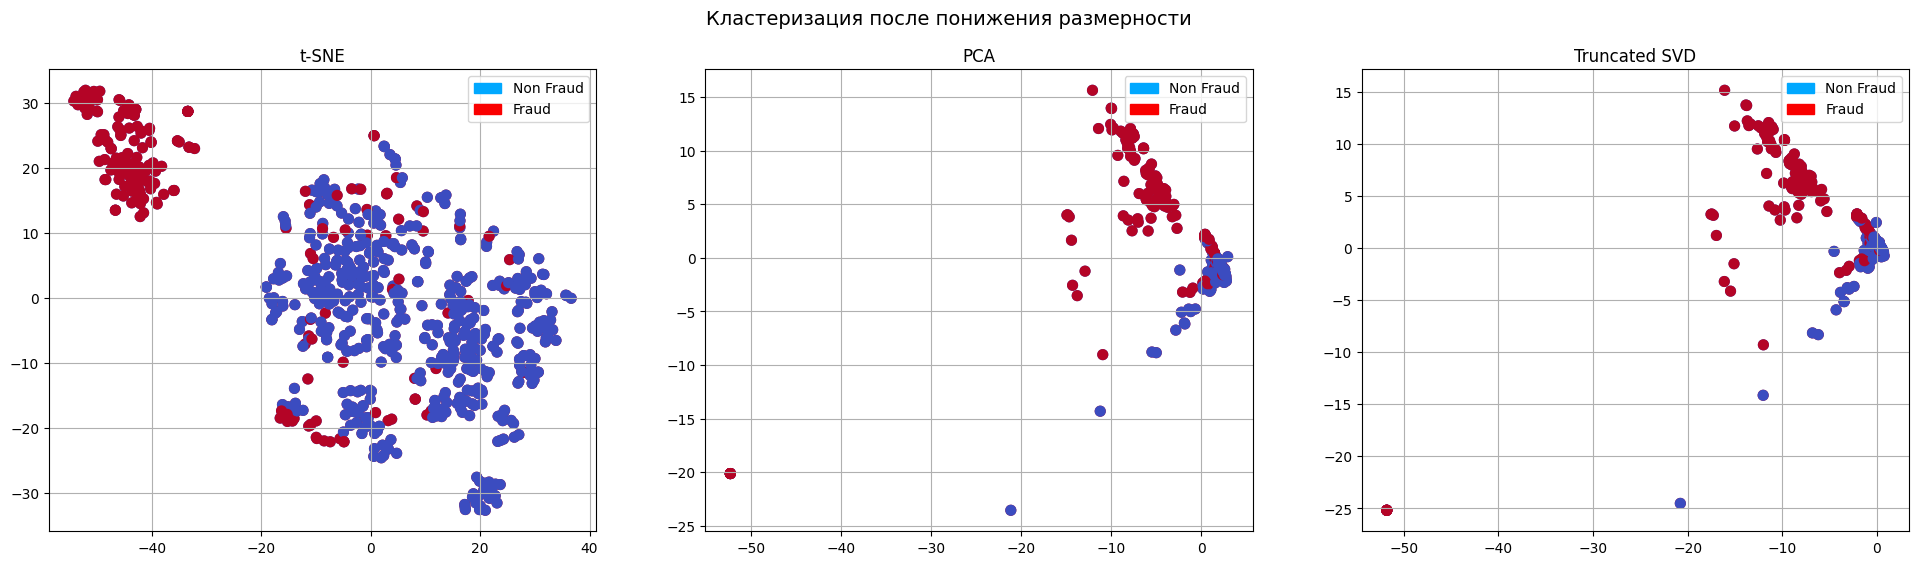

In [34]:
import matplotlib.patches as mpatches

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

# Определяем цветные метки
blue_patch = mpatches.Patch(color='#00A8FF', label='Non Fraud')
red_patch = mpatches.Patch(color='#FA0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE')
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA')
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# Truncated SVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD')
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()


<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Продолжение следует .....



<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [31]:
new_df.to_csv('/content/sample_data/creditcard_short.csv')